In [1]:
import pandas as pd
import numpy as np
pd.options.display.float_format = '{:.2f}'.format
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import scipy.stats
import pylab
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')
import yfinance as yf

# Extract Data

In [2]:
# get stock data for apple
data = yf.download('AAPL', start = '2015-01-01', end = '2021-01-01')

[*********************100%***********************]  1 of 1 completed


# Setting up raw data for analysis

In [3]:
#get only 'Adj Close','Volume'
stock = data[['Adj Close','Volume']].copy()

In [4]:
#set higher frequency to business days
stock = stock.asfreq('b')

# Inspecting data

In [5]:
#check for any nulls
stock.isnull().sum()

Adj Close    54
Volume       54
dtype: int64

In [6]:
stock = stock.fillna(method = 'backfill')

In [7]:
#check for any nulls after fill na has been applied
stock.isnull().sum()

Adj Close    0
Volume       0
dtype: int64

<AxesSubplot:title={'center':'Apple Stock'}, xlabel='Date'>

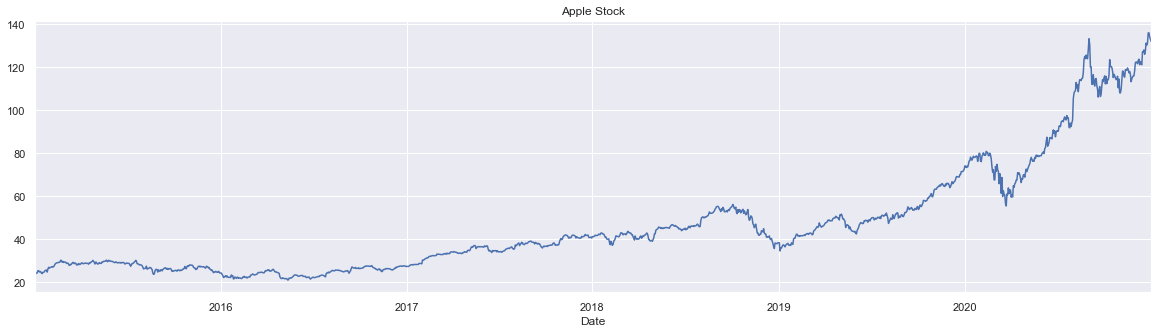

In [8]:
# inspect visually
stock['Adj Close'].plot(figsize = (20,5), title = 'Apple Stock')

In [9]:
# descriptive stats
stock.describe()

,Adj Close,Volume
count,1565.00,1565.00
mean,46.51,145249375.91
std,25.52,71087148.26
min,21.07,45448000.00
25%,27.59,96820400.00
50%,39.82,127727600.00
75%,52.35,174799600.00
max,136.05,648825200.00


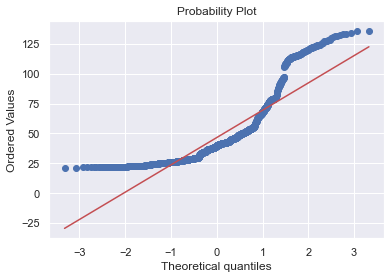

In [10]:
#QQ Plot - How the data fits a normal distribution
scipy.stats.probplot(stock['Adj Close'], plot = pylab)
pylab.show()

In [11]:
#Determining weak form stationarity
sts.adfuller(stock['Adj Close'])

(2.2788133259835885,
 0.9989413289179809,
 24,
 1540,
 {'1%': -3.4346033983723516,
  '5%': -2.863418614437511,
  '10%': -2.5677701454714117},
 4806.218689406616)

# Create AR Model Using % Returns 

In [12]:
# Using Returns
stock_r = stock['Adj Close'].pct_change(1).mul(100)
stock_r = stock_r.iloc[1:]
stock_r = stock_r.asfreq('b')
stock_r = stock_r.to_frame('returns')

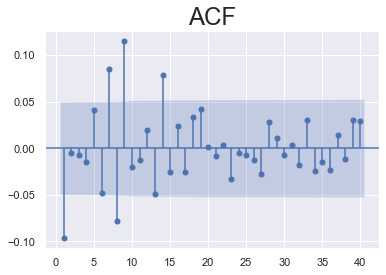

In [13]:
#ACF -- appropiate for MA models -- not appropiate for AR models
sgt.plot_acf(stock_r, lags = 40 , zero = False)
plt.title('ACF', size = 24)
plt.show()

# Fit Model

In [14]:
#P & D = 0 and q <> 0 makes ARIMA into MA model
model_ma_1 = ARIMA(stock_r, order = (0,0,1))
model_ma_6 = ARIMA(stock_r, order = (0,0,6))
model_ma_7 = ARIMA(stock_r, order = (0,0,7))
model_ma_8 = ARIMA(stock_r, order = (0,0,8))
model_ma_9 = ARIMA(stock_r, order = (0,0,9))
model_ma_13 = ARIMA(stock_r, order = (0,0,13))
model_ma_14 = ARIMA(stock_r, order = (0,0,14))

In [15]:
# fits models
results_ma_1 = model_ma_1.fit()
results_ma_6 = model_ma_6.fit()
results_ma_7 = model_ma_7.fit()
results_ma_8 = model_ma_8.fit()
results_ma_9 = model_ma_9.fit()
results_ma_13 = model_ma_13.fit()
results_ma_14 = model_ma_14.fit()

In [16]:
#LLR (Log Likely Ratio) Test
from scipy.stats import chi2
def LLR_Test(mod_1, mod_2, DF = 1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2 - L1))
    P = chi2.sf(LR, DF).round(3)
    return P

In [28]:
print(results_ma_1.summary())
print(results_ma_14.summary())
LLR_Test(model_ma_9,model_ma_14)
print('LLR Test P-Value:' + str(LLR_Test(model_ma_9,model_ma_14, DF = 5))) # df = diff of variable between models)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 1564
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -3159.974
Date:                Tue, 02 Nov 2021   AIC                           6325.949
Time:                        21:45:25   BIC                           6342.014
Sample:                    01-05-2015   HQIC                          6331.921
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1241      0.042      2.950      0.003       0.042       0.207
ma.L1         -0.0992      0.015     -6.495      0.000      -0.129      -0.069
sigma2         3.3301      0.062     53.714      0.0

In [18]:
#Analyzing residuals 
mod_res = model_ma_14.fit().resid

In [19]:
#Determining weak form stationarity for residuals
sts.adfuller(mod_res)

(-39.618126244273185,
 0.0,
 0,
 1563,
 {'1%': -3.4345407051300514,
  '5%': -2.863390943879109,
  '10%': -2.567755410866859},
 6168.081641493136)

In [20]:
mod_res.describe()

count   1564.00
mean      -0.00
std        1.80
min      -10.69
25%       -0.76
50%       -0.04
75%        0.89
max       10.19
dtype: float64

# Residuals of returns

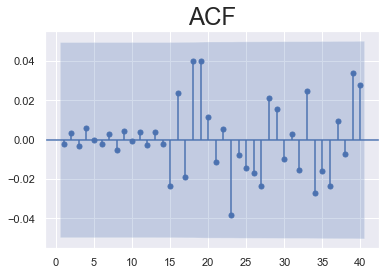

In [21]:
#ACF of residuals for returns
sgt.plot_acf(mod_res, lags = 40 , zero = False)
plt.title('ACF', size = 24)
plt.show()

<AxesSubplot:xlabel='Date'>

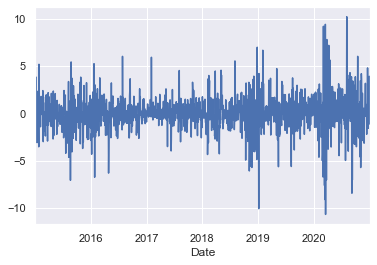

In [22]:
mod_res.plot()

# Normalized retunrs

In [23]:
#Create benchmark
benchmark = stock_r.iloc[0]
#normalize
stock_rn = stock_r.div(benchmark).mul(100)

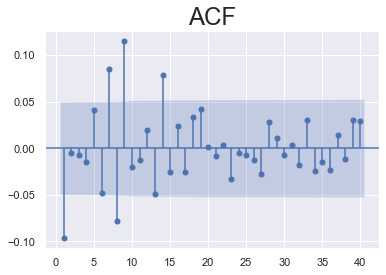

In [24]:
#ACF for normalized returns
sgt.plot_acf(stock_rn, lags = 40 , zero = False)
plt.title('ACF', size = 24)
plt.show()

In [25]:
#P & D = 0 and q <> 0 makes ARIMA into MA model
model_arn_1 = ARIMA(stock_rn, order = (0,0,1))
model_arn_7 = ARIMA(stock_rn, order = (0,0,7))
model_arn_8 = ARIMA(stock_rn, order = (0,0,8))
model_arn_9 = ARIMA(stock_rn, order = (0,0,9))
model_arn_14 = ARIMA(stock_rn, order = (0,0,14))

In [26]:
# fits models
results_man_1 = model_arn_1.fit()
results_man_7 = model_arn_7.fit()
results_man_8 = model_arn_8.fit()
results_man_9 = model_arn_9.fit()
results_man_14 = model_arn_14.fit()

In [27]:
print(results_man_9.summary())
print(results_man_14.summary())
LLR_Test(model_man_9,model_man_14)
print('LLR Test P-Value:' + str(LLR_Test(model_man_9,model_man_14, DF = 5))) # df = diff of variable between models)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 1564
Model:                 ARIMA(0, 0, 9)   Log Likelihood               -8726.800
Date:                Tue, 02 Nov 2021   AIC                          17475.600
Time:                        21:45:13   BIC                          17534.505
Sample:                    01-05-2015   HQIC                         17497.498
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.3971      1.679     -2.619      0.009      -7.687      -1.107
ma.L1         -0.0823      0.018     -4.602      0.000      -0.117      -0.047
ma.L2         -0.0179      0.016     -1.095      0.2

NameError: name 'model_man_9' is not defined

In [ ]:
#Analyzing residuals 
mod_resn = model_man_14.fit().resid

In [ ]:
mod_resn.describe()